<a href="https://colab.research.google.com/github/2003UJAN/Cat-and-Dog-Image-Classifier/blob/main/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [12]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip


PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directoriesn
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2023-11-09 13:00:38--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.1’

cats_and_dogs.zip.1 100%[===================>]  67.43M   160MB/s    in 0.4s    

2023-11-09 13:00:39 (160 MB/s) - ‘cats_and_dogs.zip.1’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [13]:
print(total_train,total_val,total_test)


2001 1001 51


In [14]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',

)
val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',

)
test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=batch_size,
    shuffle=False,
    classes=['.']
    )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


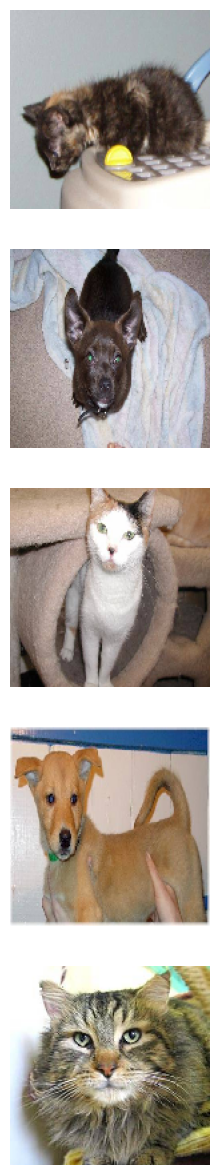

In [15]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [16]:
# 5
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=50,
                                           fill_mode='nearest',
                                           zoom_range=0.3,
                                           vertical_flip=True,
                                           width_shift_range=0.3,
                                           shear_range=0.2,
                                           )



Found 2000 images belonging to 2 classes.


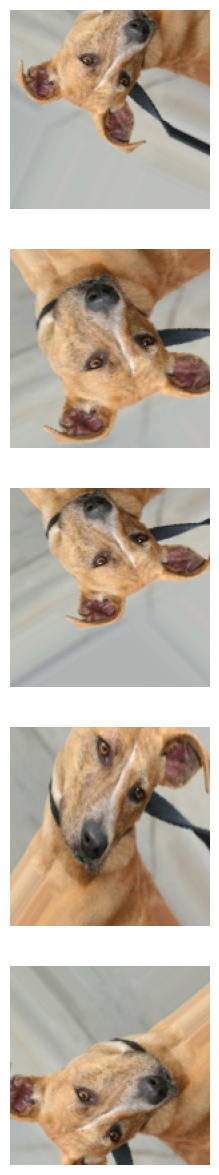

In [17]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [18]:
# 7
model = Sequential([
    Conv2D(16,(3,3),input_shape=train_data_gen.image_shape,activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(train_data_gen.num_classes,activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)       

In [19]:
# 8
history = model.fit(train_data_gen,
                    steps_per_epoch=train_data_gen.samples//batch_size,
                    validation_data=val_data_gen,
                    validation_steps=val_data_gen.samples//batch_size,
                    epochs=epochs
                    )

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


15/15 [==============================] - 72s 4s/step - loss: 0.8207 - accuracy: 0.4882 - val_loss: 0.6950 - val_accuracy: 0.4955
Epoch 2/15
15/15 [==============================] - 69s 5s/step - loss: 0.6910 - accuracy: 0.5262 - val_loss: 0.6766 - val_accuracy: 0.5580
Epoch 3/15
15/15 [==============================] - 64s 4s/step - loss: 0.6922 - accuracy: 0.5337 - val_loss: 0.6788 - val_accuracy: 0.5703
Epoch 4/15
15/15 [==============================] - 66s 4s/step - loss: 0.6807 - accuracy: 0.5502 - val_loss: 0.6640 - val_accuracy: 0.5737
Epoch 5/15
15/15 [==============================] - 62s 4s/step - loss: 0.6733 - accuracy: 0.5705 - val_loss: 0.6549 - val_accuracy: 0.6105
Epoch 6/15
15/15 [==============================] - 66s 4s/step - loss: 0.6670 - accuracy: 0.5812 - val_loss: 0.6480 - val_accuracy: 0.6116
Epoch 7/15
15/15 [==============================] - 64s 4s/step - loss: 0.6490 - accuracy: 0.6068 - val_loss: 0.6291 - val_accuracy: 0.6395
Epoch 8/15
15/15 [=============

In [20]:
val_data_gen.samples//batch_size

7

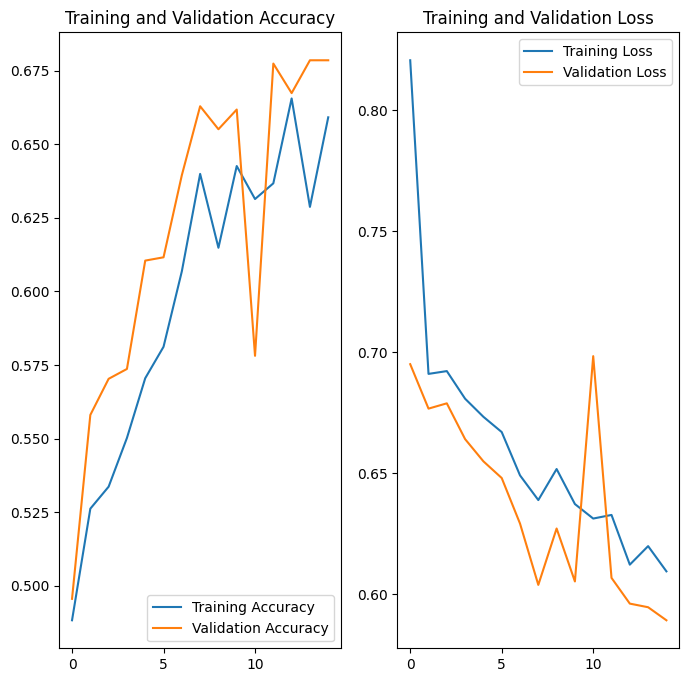

In [21]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [22]:
pred=model.predict(test_data_gen)

1/1 [==============================] - 1s 511ms/step


In [23]:
probabilities=np.argmax(pred,axis=1)
print(len(probabilities))


50


In [24]:
model.save('Cat_Dog_fcc.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 72.0% of the images of cats and dogs.
You passed the challenge!
